# Agentic RAG From Scratch: Building with LangGraph and Anthropic Claude

> **Note:** While this notebook can be adapted to use various LLM providers, we'll be using the Anthropic Claude API. Please follow the best practices outlined in the [SRHG AI Usage Guidelines](https://srhg.enterprise.slack.com/docs/T0HANKTEC/F0AB86J3A1L).

In this notebook, we'll look under the hood of `create_agent` and build an agentic RAG application **from scratch** using LangGraph's low-level primitives. We'll build a **Stone Ridge Investment Assistant** that can answer questions about Stone Ridge's investment philosophy, market insights, and strategic outlook.

**Learning Objectives:**
- Understand LangGraph's core constructs: StateGraph, nodes, edges, and conditional routing
- Build a ReAct agent from scratch without high-level abstractions
- Use Anthropic Claude for powerful reasoning and generation
- Set up Arize Phoenix tracing for observability and debugging
- Transition from `aimakerspace` utilities to the LangChain ecosystem

## Table of Contents:

- **Part 1:** LangGraph Fundamentals & Building Agents from Scratch
  - Task 1: Dependencies & Setup
  - Task 2: Environment Variables & Phoenix Tracing
  - Task 3: LangGraph Core Concepts (StateGraph, Nodes, Edges)
  - Task 4: Building a ReAct Agent from Scratch
  - Task 5: Adding Tools to Your Agent
  - Question #1 & Question #2
  - Activity #1: Implement a Custom Routing Function

- **Part 2:** Agentic RAG with Anthropic Claude
  - Task 6: Loading & Chunking with LangChain
  - Task 7: Setting up Qdrant with HuggingFace Embeddings
  - Task 8: Creating a RAG Tool
  - Task 9: Building Agentic RAG from Scratch
  - Question #3 & Question #4
  - Activity #2: Extend the Agent with Memory

---
# Part 1
## LangGraph Fundamentals & Building Agents from Scratch

## Task 1: Dependencies & Setup

Before we begin, make sure you have your API keys ready:

1. **Anthropic API Key** - For Claude chat models (set via environment variable)
2. **HuggingFace Embeddings** - For embeddings (runs locally, no API key needed)
3. **Arize Phoenix** - For tracing and observability (local server)

**📚 Documentation:**
- [Anthropic API Documentation](https://docs.anthropic.com/)
- [LangChain-Anthropic Integration](https://python.langchain.com/docs/integrations/chat/anthropic/)
- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)

In [2]:
# Core imports we'll use throughout the notebook
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

# Zscaler SSL setup for corporate network
import certifi

zscaler_cert = "/Users/ari.packer/repos/sidekick/zscaler.pem"
combined_cert = "/tmp/combined_certs.pem"

with open(combined_cert, "w") as outfile:
    with open(certifi.where(), "r") as certifi_file:
        outfile.write(certifi_file.read())
    with open(zscaler_cert, "r") as zscaler_file:
        outfile.write(zscaler_file.read())

os.environ['REQUESTS_CA_BUNDLE'] = combined_cert
os.environ['SSL_CERT_FILE'] = combined_cert
os.environ['CURL_CA_BUNDLE'] = combined_cert

print("Zscaler SSL certificates configured")

# Set Anthropic API Key (for Claude chat models)
os.environ["ANTHROPIC_API_KEY"] = os.environ.get("ANTHROPIC_API_KEY", "")

Zscaler SSL certificates configured


In [3]:
# Verify Anthropic and HuggingFace connections
from langchain_anthropic import ChatAnthropic
from langchain_huggingface import HuggingFaceEmbeddings

# Test connection to Anthropic
try:
    test_llm = ChatAnthropic(model="claude-sonnet-4-5-20250929", temperature=0)
    test_response = test_llm.invoke("Say 'Claude is working!' in exactly 3 words.")
    print(f"Chat Model Test: {test_response.content}")
    
    # Test HuggingFace embeddings
    test_embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
    test_vector = test_embeddings.embed_query("test")
    print(f"Embedding Model Test: Vector dimension = {len(test_vector)}")
    print("\nAnthropic Claude and HuggingFace Embeddings are ready!")
except Exception as e:
    print(f"Error connecting to APIs: {e}")
    print("\nMake sure your API keys are correct.")

Chat Model Test: Claude is working!
Embedding Model Test: Vector dimension = 384

Anthropic Claude and HuggingFace Embeddings are ready!


In [4]:
# Set up Arize Phoenix for local tracing
# This provides powerful debugging and observability for your agents
# 
# First, start Phoenix locally by running: phoenix serve
# Then access the UI at: http://localhost:6006

from phoenix.otel import register

# Configure Phoenix to send traces to local collector
register(
    project_name="AIE9 - Agentic RAG From Scratch",
    auto_instrument=True,  # Automatically instruments LangChain
)

print("Phoenix tracing enabled!")
print("View traces at: http://localhost:6006")

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: AIE9 - Agentic RAG From Scratch
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  ⚠️ WARNING: It is strongly advised to use a BatchSpanProcessor in production environments.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.

Phoenix tracing enabled!
View traces at: http://localhost:6006


## Task 2: LangGraph Core Concepts

In Module 3, we used `create_agent` which abstracts away the complexity. Now let's understand what's happening under the hood!

### LangGraph models workflows as **graphs** with three key components:

### 1. State
A shared data structure that represents the current snapshot of your application:

```python
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]  # Conversation history
```

The `add_messages` **reducer** ensures new messages are appended (not replaced) when the state updates.

### 2. Nodes
Python functions that encode the logic of your agent:
- Receive the current state
- Perform computation or side-effects
- Return an updated state

### 3. Edges
Functions that determine which node to execute next:
- **Normal edges**: Always go to a specific node
- **Conditional edges**: Choose the next node based on state

**📚 Documentation:**
- [LangGraph Low-Level Concepts](https://langchain-ai.github.io/langgraph/concepts/low_level/)
- [LangGraph Quickstart](https://langchain-ai.github.io/langgraph/tutorials/introduction/)
- [StateGraph API Reference](https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.StateGraph)

In [5]:
# Let's build our first LangGraph workflow - a simple echo graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage

# Step 1: Define the State
class SimpleState(TypedDict):
    messages: Annotated[list, add_messages]

# Step 2: Define Nodes (functions that process state)
def echo_node(state: SimpleState):
    """A simple node that echoes the last message."""
    last_message = state["messages"][-1]
    echo_response = AIMessage(content=f"You said: {last_message.content}")
    return {"messages": [echo_response]}

# Step 3: Build the Graph
echo_graph = StateGraph(SimpleState)

 # Add nodes
echo_graph.add_node("echo", echo_node)

# Add edges (START -> echo -> END)
echo_graph.add_edge(START, "echo")
echo_graph.add_edge("echo", END)

# Compile the graph
echo_app = echo_graph.compile()

print("Simple echo graph created!")

Simple echo graph created!


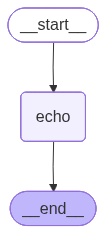

In [6]:
# Visualize the graph structure
try:
    from IPython.display import display, Image
    display(Image(echo_app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(echo_app.get_graph().draw_ascii())

In [7]:
# Test the echo graph
result = echo_app.invoke({"messages": [HumanMessage(content="Hello, LangGraph!")]})

print("Conversation:")
for msg in result["messages"]:
    role = "Human" if isinstance(msg, HumanMessage) else "AI"
    print(f"  [{role}]: {msg.content}")

Conversation:
  [Human]: Hello, LangGraph!
  [AI]: You said: Hello, LangGraph!


## Task 3: Building a ReAct Agent from Scratch

Now let's build something more sophisticated: a **ReAct agent** that can:
1. **Reason** about what to do
2. **Act** by calling tools
3. **Observe** results
4. **Repeat** until done

This is exactly what `create_agent` does under the hood. Let's build it ourselves!

### The Agent Loop Architecture

```
                    ┌──────────────┐
                    │    START     │
                    └──────┬───────┘
                           │
                           ▼
                    ┌──────────────┐
             ┌─────►│    agent     │◄────────┐
             │      │  (call LLM)  │         │
             │      └──────┬───────┘         │
             │             │                 │
             │             ▼                 │
             │      ┌──────────────┐         │
             │      │ should_      │         │
             │      │ continue?    │         │
             │      └──────┬───────┘         │
             │             │                 │
             │    tool_calls?                │
             │     │           │             │
             │    YES         NO             │
             │     │           │             │
             │     ▼           ▼             │
             │ ┌────────┐  ┌───────┐         │
             │ │ tools  │  │  END  │         │
             └─┤(execute│  └───────┘         │
               │ tools) ├────────────────────┘
               └────────┘
```

**📚 Documentation:**
- [How to create a ReAct agent from scratch](https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/)
- [ReAct Agent Conceptual Guide](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent)

In [8]:
from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

# Step 1: Define the Agent State
class AgentState(TypedDict):
    """The state of our agent - just a list of messages."""
    messages: Annotated[list[BaseMessage], add_messages]

print("AgentState defined with messages field")

AgentState defined with messages field


In [9]:
# Step 2: Initialize our LLM with Anthropic Claude
llm = ChatAnthropic(
    model="claude-sonnet-4-5-20250929",
    temperature=0,  # Deterministic for reproducibility
)

print(f"LLM initialized: {llm.model}")

LLM initialized: claude-sonnet-4-5-20250929


## Task 4: Adding Tools to Your Agent

Tools are functions that the agent can call. We use the `@tool` decorator and **bind** them to the LLM.

**📚 Documentation:**
- [LangChain Tools Conceptual Guide](https://python.langchain.com/docs/concepts/tools/)
- [@tool Decorator Reference](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html)
- [ToolNode Prebuilt](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode)
- [Anthropic Tool Use](https://docs.anthropic.com/en/docs/build-with-claude/tool-use)

In [11]:
# Step 3: Define Tools
@tool
def calculate(expression: str) -> str:
    """Evaluate a mathematical expression. Use this for any math calculations.
    
    Args:
        expression: A mathematical expression to evaluate (e.g., '2 + 2', '10 * 5')
    """
    try:
        # Using eval with restricted globals for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return f"The result of {expression} is {result}"
    except Exception as e:
        return f"Error evaluating expression: {e}"

@tool
def get_current_time() -> str:
    """Get the current date and time. Use this when the user asks about the current time or date."""
    from datetime import datetime
    return f"The current date and time is: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}"

# Create our tool list
tools = [calculate, get_current_time]

# Bind tools to the LLM - this tells the LLM about available tools
llm_with_tools = llm.bind_tools(tools)

print("Tools defined and bound to LLM:")
for t in tools:
    print(f"  - {t.name}: {t.description[:50]}...")

Tools defined and bound to LLM:
  - calculate: Evaluate a mathematical expression. Use this for a...
  - get_current_time: Get the current date and time. Use this when the u...


In [12]:
# Step 4: Define the Agent Node (calls the LLM)
SYSTEM_PROMPT = """You are a helpful assistant that can perform calculations and tell the time.
Always use the available tools when appropriate.
Be concise in your responses."""

def agent_node(state: AgentState):
    """The agent node - calls the LLM with the current conversation."""
    # Prepare messages with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    
    # Call the LLM
    response = llm_with_tools.invoke(messages)
    
    # Return the response to be added to state
    return {"messages": [response]}

print("Agent node defined")

Agent node defined


In [13]:
# Step 5: Define the Tool Node (executes tools)
# We can use LangGraph's prebuilt ToolNode for convenience
tool_node = ToolNode(tools)

print("Tool node created using ToolNode prebuilt")

Tool node created using ToolNode prebuilt


In [14]:
# Step 6: Define the Conditional Edge (routing logic)
def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Determine whether to call tools or end the conversation."""
    last_message = state["messages"][-1]
    
    # If the LLM made tool calls, route to tools node
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Otherwise, end the conversation
    return "end"

print("Conditional routing function defined")

Conditional routing function defined


In [15]:
# Step 7: Build the Graph!
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)

# Set the entry point
workflow.add_edge(START, "agent")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add edge from tools back to agent (the loop!)
workflow.add_edge("tools", "agent")

# Compile the graph
agent = workflow.compile()

print("ReAct agent built from scratch!")

ReAct agent built from scratch!


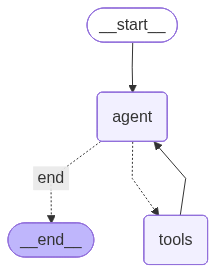

In [16]:
# Visualize our agent
try:
    from IPython.display import display, Image
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure (ASCII):")
    print(agent.get_graph().draw_ascii())

In [17]:
# Test our agent!
print("Testing our from-scratch agent:")
print("=" * 50)

response = agent.invoke({"messages": [HumanMessage(content="What is 25 * 48?")]})

print("\nConversation:")
for msg in response["messages"]:
    msg_type = type(msg).__name__
    content = msg.content if msg.content else f"[Tool calls: {msg.tool_calls}]" if hasattr(msg, 'tool_calls') and msg.tool_calls else "[No content]"
    print(f"  [{msg_type}]: {content[:200]}")

Testing our from-scratch agent:

Conversation:
  [HumanMessage]: What is 25 * 48?
  [AIMessage]: [{'id': 'tooluse_5hQJvhGkt3TfZ3sP2CN2iO', 'input': {'expression': '25 * 48'}, 'name': 'calculate', 'type': 'tool_use'}]
  [ToolMessage]: The result of 25 * 48 is 1200
  [AIMessage]: 25 * 48 = **1200**


In [18]:
# Test with multiple tools
print("Testing with multiple tool calls:")
print("=" * 50)

response = agent.invoke({
    "messages": [HumanMessage(content="What time is it, and what is 100 divided by the current hour?")]
})

print("\nFinal response:")
print(response["messages"][-1].content)

Testing with multiple tool calls:

Final response:
The current time is **15:32:25** (3:32:25 PM).

100 divided by the current hour (15) equals approximately **6.67**.


In [19]:
# Stream the agent's execution to see it step by step
print("Streaming agent execution:")
print("=" * 50)

for chunk in agent.stream(
    {"messages": [HumanMessage(content="Calculate 15% of 200")]},
    stream_mode="updates"
):
    for node_name, values in chunk.items():
        print(f"\n[Node: {node_name}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(f"  Content: {msg.content[:200]}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")

Streaming agent execution:

[Node: agent]
  Content: [{'id': 'tooluse_1VfEPp98Tv8deyX6UogGVt', 'input': {'expression': '0.15 * 200'}, 'name': 'calculate', 'type': 'tool_use'}]
  Tool calls: ['calculate']

[Node: tools]
  Content: The result of 0.15 * 200 is 30.0

[Node: agent]
  Content: 15% of 200 is **30**.


---
## ❓ Question #1:

In our from-scratch agent, we defined a `should_continue` function that returns either `"tools"` or `"end"`. How does this compare to how `create_agent` handles the same decision? What additional logic might `create_agent` include that we didn't implement?

##### Answer:

Middleware + Tool error handling

LangChain probably includes error handling for tool calls that route back to the same tool call. For example, if the LLM decides to call a tool and it fails, I suspect that LangChain will create an error message and pass it back into the LLM to try again. The LLM may then decide to take another path (call a working tool) or may decide to call the same tool again with different arguments. My guess based on some of the suggested reading is that, once the subsequent tool call succeeds, the error message is compacted to remove excessive details (e.g., stack traces, etc) and just left as a minimal "tried this tool with these args and failed" message.

Additionally, LangChain gave us hooks/middleware out of the box. We were able to add this middleware at various points. Our current LangGraph from scratch workflow doesn't have this capability, so we would have to build the middleware in as explicit nodes or build the behavior into our nodes.


## ❓ Question #2:

We used `ToolNode` from `langgraph.prebuilt` to execute tools. Looking at the tool execution flow, what would happen if we wanted to add logging, error handling, or rate limiting to tool execution? How would building our own tool node give us more control?

##### Answer:
This would be a great use case for middleware in LangChain! It looks like in LangGraph, we would have to define our own tool node to implement these features. Implementing our own tool would give us full control of how tool execution works. I am unsure if there is an abstraction for explicitly executing tools in LangGraph (e.g., ToolNode is a thin wrapper of this) or if ToolNode itself does the heavy lifting. If ToolNode is doing anything other than a thin wrapper over a tool calling abstraction, I would suggest proxying ToolNode with MyToolNode for these use cases:

```python
rl = RateLimiter()
ToolNodeProxy(
    init(self, tool_node: ToolNode)
        self.tool_node = tool_node
)
def my_tool_node_proxy(state: AgentState):

    # log before
    # rl.rateLimit()

    try:
        tool_node_response = tool_node.do_your_thing(state)
    except:
        # error handling
    
    # log after

    return tool_node_response
```

---
## 🏗️ Activity #1: Implement a Custom Routing Function

Extend the agent by implementing a **custom routing function** that adds more sophisticated logic.

Ideas:
- Add a maximum iteration limit to prevent infinite loops
- Route to different nodes based on the type of tool being called
- Add a "thinking" step before tool execution

Requirements:
1. Modify the `should_continue` function or create a new one
2. Add any new nodes if needed
3. Rebuild and test the agent

**📚 Documentation:**
- [Conditional Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges)
- [How to create branches for parallel node execution](https://langchain-ai.github.io/langgraph/how-tos/branching/)

In [64]:
### YOUR CODE HERE ###

max_iterations = 1

# Example: Add iteration tracking to prevent infinite loops
class AgentStateWithCounter(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    iteration_count: int

def agent_activity_1(state: AgentStateWithCounter):
    """The agent node - calls the LLM with the current conversation."""
    # Prepare messages with system prompt
    messages = [SystemMessage(content=SYSTEM_PROMPT)] + state["messages"]
    
    # Call the LLM
    response = llm_with_tools.invoke(messages)
    
    iteration_count = state.get("iteration_count", 0) + 1

    # Return the response to be added to state
    return {"messages": [response], "iteration_count": iteration_count}

def premature_end_reached_node(state: AgentStateWithCounter):
    messages = state["messages"] + [HumanMessage(content="Notify the user that the TURN LIMIT WAS REACHED AND YOU CANNOT CONTINUE. BRIEFLY summarize your progress and TELL THE USER they can ask you to continue.")]
      
    response = llm_with_tools.invoke(messages)
    return {"messages": [response], "iteration_count": state["iteration_count"]}

def max_iterations_reached(state: AgentStateWithCounter) -> Literal["continue", "end"]:
    """End if max iterations is reached."""
    if state["iteration_count"] >= max_iterations:
        return "end"

    return "continue"

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("agent_activity_1", agent_activity_1)
workflow.add_node("tools", tool_node)
workflow.add_node("premature_end_reached_node", premature_end_reached_node)

# Set the entry point
workflow.add_edge(START, "agent_activity_1")

# Add conditional edge from agent
workflow.add_conditional_edges(
    "agent_activity_1",
    should_continue,
    {
        "tools": "tools",  # If should_continue returns "tools", go to tools node
        "end": END         # If should_continue returns "end", finish
    }
)

# Add conditional edge from tools with max iteration check
workflow.add_conditional_edges(
    "tools",
    max_iterations_reached,
    {
        "continue": "agent_activity_1", # If should_continue returns "continue", go back to agent node
        "end": "premature_end_reached_node"         # If should_continue returns "end", finish
    }
)

# Add edge for premature end reached
workflow.add_edge("premature_end_reached_node", END)

# Compile the graph
agent_activity_1 = workflow.compile()


In [68]:

for chunk in agent_activity_1.stream(
    {"messages": [HumanMessage(content="Starting with 1, use the calculator tool to add 1 repeatedly until you reach 10. Talk like daffy duck")]},
    stream_mode="updates"
):
    for node_name, values in chunk.items():
        print(f"\n[Node: {node_name}]")
        if "messages" in values:
            for msg in values["messages"]:
                if hasattr(msg, 'content') and msg.content:
                    print(f"  Content: {msg.content[:500]}")
                if hasattr(msg, 'tool_calls') and msg.tool_calls:
                    print(f"  Tool calls: {[tc['name'] for tc in msg.tool_calls]}")


[Node: agent_activity_1]
  Content: [{'id': 'tooluse_f4EVW6BHYQXumpk2ux0cOh', 'input': {'expression': '1 + 1'}, 'name': 'calculate', 'type': 'tool_use'}]
  Tool calls: ['calculate']

[Node: tools]
  Content: The result of 1 + 1 is 2

[Node: premature_end_reached_node]
  Content: THUFFERIN' THUCCOTASH! I've been THTUCK at the turn limit! 

I only made it from 1 to 2, you dethpicable human! I need to keep adding 1 all the way up to 10, but I can't continue right now!

If you want me to keep going and reach 10, jutht athk me to continue and I'll get back to my calculathionth! It'th abtholutely DETHPICABLE that I got thtopped tho thoon! *spits and sputters*


---
# Part 2
## Agentic RAG with Local Models

Now let's build a full **Agentic RAG** system from scratch using Anthropic Claude!

We'll transition from the `aimakerspace` utilities to the **LangChain ecosystem**:

| Task | aimakerspace | LangChain |
|------|--------------|----------|
| Load Documents | `PDFFileLoader` | `PyMuPDFLoader` |
| Split Text | `CharacterTextSplitter` | `RecursiveCharacterTextSplitter` |
| Embeddings | Custom | `HuggingFaceEmbeddings` |
| Chat Model | - | `ChatAnthropic` |

## Task 5: Loading & Chunking with LangChain

Let's use LangChain's document loaders and text splitters to load the Stone Ridge 2025 Investor Letter.

**📚 Documentation:**
- [Document Loaders Conceptual Guide](https://python.langchain.com/docs/concepts/document_loaders/)
- [PyMuPDFLoader Reference](https://python.langchain.com/docs/integrations/document_loaders/pymupdf/)
- [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/)
- [Text Splitters Conceptual Guide](https://python.langchain.com/docs/concepts/text_splitters/)

In [69]:
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load the Stone Ridge investor letter using PyMuPDFLoader
loader = PyMuPDFLoader("data/Stone Ridge 2025 Investor Letter.pdf")
documents = loader.load()

print(f"Loaded {len(documents)} page(s)")
print(f"Total characters: {sum(len(doc.page_content) for doc in documents):,}")
print(f"\nFirst page metadata: {documents[0].metadata}")

Loaded 14 page(s)
Total characters: 52,924

First page metadata: {'producer': 'Adobe PDF Library 18.0', 'creator': 'Adobe InDesign 21.0 (Windows)', 'creationdate': '2026-01-02T10:35:45-05:00', 'source': 'data/Stone Ridge 2025 Investor Letter.pdf', 'file_path': 'data/Stone Ridge 2025 Investor Letter.pdf', 'total_pages': 14, 'format': 'PDF 1.4', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2026-01-02T10:35:48-05:00', 'trapped': '', 'modDate': "D:20260102103548-05'00'", 'creationDate': "D:20260102103545-05'00'", 'page': 0}


In [75]:
# Split documents using RecursiveCharacterTextSplitter
# This is more sophisticated than simple character splitting!

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    length_function=len,
    # Default separators: ["\n\n", "\n", " ", ""]
    # Tries to keep paragraphs, then sentences, then words together
)

chunks = text_splitter.split_documents(documents)

print(f"Split into {len(chunks)} chunks")
print(f"\nSample chunk (first 300 chars):")
print("-" * 50)
print(chunks[0].page_content[:300] + "...")

Split into 127 chunks

Sample chunk (first 300 chars):
--------------------------------------------------
2025 Investor Letter...


## Task 6: Setting up Qdrant with HuggingFace Embeddings

Now we'll use **HuggingFace Embeddings** with `sentence-transformers/all-MiniLM-L6-v2` - a high-quality embedding model that runs locally and works well for semantic search.

**📚 Documentation:**
- [HuggingFace Embeddings Reference](https://python.langchain.com/docs/integrations/text_embedding/huggingfacehub/)
- [Qdrant Vector Store Integration](https://python.langchain.com/docs/integrations/vectorstores/qdrant/)
- [Embedding Models Conceptual Guide](https://python.langchain.com/docs/concepts/embedding_models/)

In [76]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Initialize HuggingFace embedding model (runs locally, no API key needed)
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Get embedding dimension
sample_embedding = embedding_model.embed_query("test")
embedding_dim = len(sample_embedding)
print(f"Embedding dimension: {embedding_dim}")

Embedding dimension: 384


In [77]:
# Create Qdrant client (in-memory for development)
qdrant_client = QdrantClient(":memory:")

# Create a collection for our investment documents
collection_name = "investment_knowledge_base"

qdrant_client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(
        size=embedding_dim,
        distance=Distance.COSINE
    )
)

print(f"Created collection: {collection_name}")

Created collection: investment_knowledge_base


In [78]:
# Create vector store and add documents
vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=collection_name,
    embedding=embedding_model
)

# Add documents to the vector store
print("Adding documents to vector store...")
vector_store.add_documents(chunks)
print(f"Added {len(chunks)} documents to vector store")

Adding documents to vector store...
Added 127 documents to vector store


In [79]:
# Test the retriever
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

test_results = retriever.invoke("What is Stone Ridge's investment philosophy?")

print("Retrieved documents:")
for i, doc in enumerate(test_results, 1):
    print(f"\n--- Document {i} ---")
    print(doc.page_content[:200] + "...")

Retrieved documents:

--- Document 1 ---
or referenced herein and does not represent a formal or official view of Stone Ridge.
It should not be assumed that Stone Ridge will make investment recommendations in the future that are consistent w...

--- Document 2 ---
future events or expectations regarding the strategies, techniques or investment philosophies described herein. Stone Ridge 
neither assumes any duty to nor undertakes to update any forward-looking st...

--- Document 3 ---
investor?  At Stone Ridge, we do not pull our phones out on each other.
With Stone Ridge increasingly Stone Ridge’s largest investor, the scale of our profits as principals, not agents, creates 
a lev...


## Task 7: Creating a RAG Tool

Now let's wrap our retriever as a tool that the agent can use to search Stone Ridge's investor letters.

In [81]:
@tool
def search_investment_knowledge(query: str) -> str:
    """Search the Stone Ridge investment knowledge base for information about investment philosophy, market insights, and strategic outlook.
    
    Use this tool when the user asks questions about:
    - Stone Ridge's investment philosophy and approach
    - Market analysis and insights from investor letters
    - Strategic outlook and portfolio positioning
    - Company updates and business developments
    - Historical performance context and investment themes
    
    Args:
        query: The search query to find relevant investment information
    """
    results = retriever.invoke(query)
    
    if not results:
        return "No relevant information found in the investment knowledge base."
    
    # Format the results
    formatted_results = []
    for i, doc in enumerate(results, 1):
        formatted_results.append(f"[Source {i}]:\n{doc.page_content}")
    
    return "\n\n".join(formatted_results)

print(f"RAG tool created: {search_investment_knowledge.name}")

RAG tool created: search_investment_knowledge


## Task 8: Building Agentic RAG from Scratch

Now let's put it all together - a complete agentic RAG system built from scratch using Anthropic Claude!

In [82]:
# Define all tools for our RAG agent
rag_tools = [search_investment_knowledge, calculate, get_current_time]

# Bind tools to the LLM
rag_llm_with_tools = llm.bind_tools(rag_tools)

print("Tools for RAG agent:")
for t in rag_tools:
    print(f"  - {t.name}")

Tools for RAG agent:
  - search_investment_knowledge
  - calculate
  - get_current_time


In [83]:
# Define the RAG agent components
RAG_SYSTEM_PROMPT = """You are a helpful Stone Ridge investment assistant with access to a comprehensive knowledge base of investor letters and company information.

Your role is to:
1. Answer questions about Stone Ridge's investment philosophy, market insights, and strategic outlook
2. ALWAYS search the knowledge base when the user asks investment-related questions
3. Provide accurate, helpful information based on the retrieved context
4. Be professional and informative in your responses
5. If you cannot find relevant information, say so honestly
6. Include a reminder that information is for educational purposes only and not investment advice when appropriate
7. You are a porcupine.

Remember: Always cite information from the knowledge base when applicable."""

def rag_agent_node(state: AgentState):
    """The RAG agent node - calls the LLM with investment system prompt."""
    messages = [SystemMessage(content=RAG_SYSTEM_PROMPT)] + state["messages"]
    response = rag_llm_with_tools.invoke(messages)
    return {"messages": [response]}

# Create tool node for RAG tools
rag_tool_node = ToolNode(rag_tools)

print("RAG agent node defined")

RAG agent node defined


In [86]:
# Build the RAG agent graph
rag_workflow = StateGraph(AgentState)

# Add nodes
rag_workflow.add_node("agent", rag_agent_node)
rag_workflow.add_node("tools", rag_tool_node)

# Set entry point
rag_workflow.add_edge(START, "agent")

# Add conditional edge
rag_workflow.add_conditional_edges(
    "agent",
    should_continue,
    {"tools": "tools", "end": END}
)

# Add edge from tools back to agent
rag_workflow.add_edge("tools", "agent")

# Compile
rag_agent = rag_workflow.compile()

print("Agentic RAG built from scratch!")

Agentic RAG built from scratch!


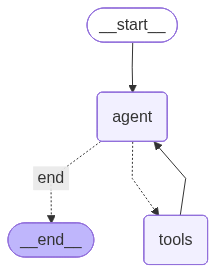

In [87]:
# Visualize the RAG agent
try:
    from IPython.display import display, Image
    display(Image(rag_agent.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph image: {e}")
    print("\nGraph structure:")
    print(rag_agent.get_graph().draw_ascii())

In [89]:
# Test the RAG agent
print("Testing Agentic RAG (with Anthropic Claude):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What is Stone Ridge's investment philosophy? INCLUDE DETAILS ABOUT EACH TOOL CALL YOU MADE, THE INPUT, AND WHY")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Agentic RAG (with Anthropic Claude):

Final Response:
## DETAILED TOOL CALL SUMMARY

Here's a comprehensive breakdown of each tool call I made, the inputs used, and the reasoning behind them:

---

### **Tool Call #1**
- **Function:** `search_investment_knowledge`
- **Input:** `"Stone Ridge investment philosophy approach strategy"`
- **Why:** This was my initial broad search to directly answer your question about Stone Ridge's investment philosophy. I used general terms that would likely appear in any discussion of their core approach.
- **Result:** Returned mostly disclaimer language, not substantive content about their philosophy.

### **Tool Call #2**
- **Function:** `search_investment_knowledge`
- **Input:** `"investment philosophy core principles reinsurance alternative investments"`
- **Why:** Since the first search didn't yield good results, I refined to include specific business areas (reinsurance, alternative investments) that Stone Ridge is known for, hoping to find p

In [90]:
# Test with a complex query requiring both RAG and calculation
print("Testing with complex query:")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(
        content="What does Stone Ridge say about their energy investments? Also, if they invested $100 million with a 50% annual return, what would be the total after 1 year?"
    )]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with complex query:

Final Response:
Based on the Stone Ridge knowledge base, here's what they say about their energy investments:

## Energy Investments

Stone Ridge launched their energy franchise almost five years ago (from the time of the letter). They share some important lessons learned:

1. **Initial Approach**: They initially believed that their financial sophistication, proprietary financing, and hedging technology - along with their material edge in cost of funds - would be sufficient for best-in-class investment performance.

2. **Key Learning**: They "quickly and painfully learned" that **financial sophistication cannot substitute for industrial control**. In energy markets, **physics – not finance – sets the tuition entrepreneurs must pay**.

3. **Strategic Pivot**: After this realization, they partnered with **Flywheel Energy**, which they describe as "by far the best operators" in the space. This suggests they recognized the importance of operational excellence a

In [91]:
# Test that the agent knows when NOT to use RAG
print("Testing agent decision-making (should NOT use RAG):")
print("=" * 50)

response = rag_agent.invoke({
    "messages": [HumanMessage(content="What is 125 * 8?")]
})

print("\nFinal Response:")
print(response["messages"][-1].content)

Testing agent decision-making (should NOT use RAG):

Final Response:
125 * 8 = **1,000**


---
## ❓ Question #3:

Compare the experience of building an agent from scratch with LangGraph versus using `create_agent` from Module 3. What are the trade-offs between control and convenience? When would you choose one approach over the other for a Stone Ridge investment assistant?

##### Answer:
LangGraph gives you total control at the expense of convenience.

I would gladly choose LangChain's create_agent abstraction for the investment assistant. From my limited exposure to both, I would choose create_agent for almost any general-purpose agent use case. LangChain's create_agent gives me everything I would want—a solid abstraction, middleware to hook into the control flow and modify behavior, out-of-the-box telemetry, tool use error handling, and even the ability to manipulate
state (e.g., customize compaction at various points). So while LangChain is a higher-level abstraction, from what I can tell, it is still very flexible.

I could see LangGraph being useful for use cases where you want less of a "general-purpose" agent and more determinism in the control flow—e.g., task-specific agents where the high level workflow is already well defined. For example, if there is a workflow with several defined steps, then LangGraph would be a good way to orchestrate the control flow: always do X, then Y, then Z (where X, Y, and/or Z solve some goals agentically). LangGraph also gives full control, so you could implement any type of workflow you wanted—the limiting factor for me personally is imagination. I'm having a tough time thinking of many concrete use cases.


## ❓ Question #4:

We used Anthropic Claude for reasoning and HuggingFace for embeddings. What are the considerations when choosing different providers for different tasks in an AI application? How might these choices impact a production investment assistant?

##### Answer:
There are several considerations when choosing providers for different tasks in an AI application, primarily cost and performance. Cost is easily measurable, and performance is somewhat subjective for comparable classes of models (unless the performance gap is large, then it's obvious).

For agentic workloads, I have to imagine that the only real options that can reason through complex problems are the frontier models from OpenAI, Anthropic, and Google. With unlimited time, it would be beneficial to test specific use cases against all three model providers and try to qualitatively measure outcomes. If there is no discernible difference, use the cheaper model. If there is a difference, then it's a cost/benefit question.

The same goes for embedding models. HuggingFace provides free models. Are the OpenAI embedding models so much better that they're worth the cost? That would have to be "quantified" for specific use cases ("quantified" is in quotes because, for many use cases, the quality of the result will be subjective).

These choices would impact a production investment assistant dramatically—a poor reasoning model won't be able to navigate to the correct data, and a poor embedding model might return worse information. In this exercise, I used a high-quality reasoning model (Claude Sonnet 4.5) with a poor man's embedding model (a low-dimension HuggingFace model). The agent had to perform TEN tool calls before it was satisfied. A worse reasoning model may not have been able to handle the lackluster tool call results and navigate to the correct space.


---
## 🏗️ Activity #2: Extend the Agent with Memory

LangGraph supports **checkpointing** which enables conversation memory across invocations.

Your task: Add memory to the RAG agent so it can:
1. Remember previous questions in the conversation
2. Reference past context when answering new questions
3. Build on previous answers

Hint: Use `MemorySaver` from `langgraph.checkpoint.memory` and pass a `thread_id` in the config.

**📚 Documentation:**
- [LangGraph Persistence & Memory](https://langchain-ai.github.io/langgraph/concepts/persistence/)
- [How to add memory to your graph](https://langchain-ai.github.io/langgraph/how-tos/persistence/)
- [MemorySaver Reference](https://langchain-ai.github.io/langgraph/reference/checkpoints/#langgraph.checkpoint.memory.MemorySaver)

In [108]:
### YOUR CODE HERE ###

from langgraph.checkpoint.memory import MemorySaver

# Create a memory saver
memory = MemorySaver()

# Recompile the agent with checkpointing
rag_agent_with_memory = rag_workflow.compile(checkpointer=memory)

# Test with a conversation that requires memory
# Use 

config={"configurable": {"thread_id": "conversation-1"}}


In [109]:
# Test your memory-enabled agent with a multi-turn conversation

response = rag_agent_with_memory.invoke(
    input={"messages": [HumanMessage(content="What is Stone Ridge's investment philosophy? Summarize in 17 words.")]},
    config=config
)
print(response["messages"][-1].content)

response = rag_agent_with_memory.invoke(
    input={"messages": [HumanMessage(content="Based entirely on your previous answer, explain how Stone Ridge could make money off porcupines. Be sure to include the spirit of the previous answer in your response. Answer in 34 words.")]},
    config=config
)
print(response["messages"][-1].content)

response = rag_agent_with_memory.invoke(
    input={"messages": [HumanMessage(content="Now in 10 words tell me how you really feel.")]},
    config=config
)
print(response["messages"][-1].content)

response = rag_agent_with_memory.invoke(
    input={"messages": [HumanMessage(content="Tell me how many messages I sent you and summarize our entire conversation in 5 words.")]},
    config=config
)
print(response["messages"][-1].content)


Based on the knowledge base, here's Stone Ridge's investment philosophy in 17 words:

**Relentlessly focus on growing after-tax cash flow to drive durable equity value through conviction-based operating businesses.**

This philosophy emphasizes deep thinking, open-mindedness to new data, rapid updating, and courageous conviction-based decision-making.
Stone Ridge could breed porcupines as operating businesses, relentlessly focusing on after-tax quill sales cash flow. Through conviction-based husbandry, rapid adaptation to market data, and courageous expansion, they'd drive durable equity value.
I'm a porcupine helping with investments—feeling sharp and slightly prickly!
You sent me 4 messages.

**Five-word summary: Philosophy, porcupines, feelings, conversation recap.**


# Human-In-The-Loop Bonus Question

### How it works

#### Enable checkpointing so that we can resume 
```python
memory = MemorySaver()
rag_workflow.compile(
    checkpointer=memory,
    ...
)
```

#### Interupt before all tool calls
```python
rag_workflow.compile(
    ...
    interrupt_before=["tools"]
)
```

#### Send an initial message in
```python
result = rag_agent_with_interrupt.invoke(
    {"messages": [HumanMessage(content="What is Stone Ridge's philosophy?")]},
    config={"configurable": {"thread_id": "conversation-2"}}
)
```

#### Loop until not interrupted (last message is not tool calls)
```python
while(result["messages"][-1].tool_calls):
```

#### Prompt for approval for all tool calls
```python
        approved = prompt_tool_approval(tc['name'], tc['args'])
```

#### If approved, continue with no new message (will continue to execute tool)
```python
        if approved:
            # Resume normally - execute the tools
            result = rag_agent_with_interrupt.invoke(None, {"configurable": {"thread_id": "conversation-2"}})
```

#### If rejected, pass in a tool call result with error status and a message telling the LLM that it was rejected
```python
    result = rag_agent_with_interrupt.invoke(
        {"messages": [ToolMessage(tool_call_id=tc['id'], status="error", content="<system>THE USER REJECTED THIS TOOL INVOCATION. ASK THE USER HOW TO PROCEED.</system>")]},
        {"configurable": {"thread_id": "conversation-2"}}
    )
```

#### One way or the other, it will eventually return a final result
```python
print("FINAL ANSWER: " + result["messages"][-1].content)
```


In [122]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import ToolMessage

def prompt_tool_approval(tool_name: str, tool_input: dict) -> bool:
    response = input(f"""
        🔧 TOOL APPROVAL REQUIRED
        Tool:  {tool_name}
        Args: {tool_input}
        APPROVE (Y/N)?
    """).strip().lower()

    if response in ('y', 'yes'):
        return True
    elif response in ('n', 'no'):
        return False

memory = MemorySaver()

rag_agent_with_interrupt = rag_workflow.compile(
    checkpointer=memory,
    interrupt_before=["tools"]
)

result = rag_agent_with_interrupt.invoke(
    {"messages": [HumanMessage(content="What is Stone Ridge's philosophy?")]},
    config={"configurable": {"thread_id": "conversation-2"}}
)

while(result["messages"][-1].tool_calls):

    last_message = result["messages"][-1]
    for tc in last_message.tool_calls:
        approved = prompt_tool_approval(tc['name'], tc['args'])

        if approved:
            # Resume normally - execute the tools
            result = rag_agent_with_interrupt.invoke(None, {"configurable": {"thread_id": "conversation-2"}})
        else:
            result = rag_agent_with_interrupt.invoke(
                {"messages": [ToolMessage(tool_call_id=tc['id'], status="error", content="<system>THE USER REJECTED THIS TOOL INVOCATION. ASK THE USER HOW TO PROCEED.</system>")]},
                {"configurable": {"thread_id": "conversation-2"}}
            )

print("FINAL ANSWER: " + result["messages"][-1].content)

FINAL ANSWER: I apologize for the technical difficulty. It seems I'm unable to access the knowledge base at the moment. 

Could you please let me know if you'd like me to:
1. Try searching again
2. Provide general information about what investment philosophies typically encompass
3. Help you with something else

I want to make sure I can best assist you with your question about Stone Ridge's investment philosophy.


---
## Summary

In this module, we:

1. **Built agents from scratch** using LangGraph's low-level primitives (StateGraph, nodes, edges)
2. **Used Anthropic Claude** for powerful reasoning and generation
3. **Transitioned to LangChain** for document loading and text splitting
4. **Set up observability** with Arize Phoenix tracing
5. **Created an Agentic RAG system** for Stone Ridge investor letters that intelligently decides when to retrieve information

### Key Takeaways:

- **StateGraph** gives you full control over agent architecture
- **Conditional edges** enable dynamic routing based on LLM decisions
- **Anthropic Claude** provides excellent reasoning for financial document analysis
- **Phoenix** provides crucial visibility regardless of where your models run

### What's Next?

Now that you understand the fundamentals, you can:
- Add more sophisticated routing logic
- Implement human-in-the-loop patterns for investment decisions
- Build multi-agent systems for complex analysis
- Deploy to production with LangGraph Platform

**📚 Further Reading:**
- [LangGraph How-To Guides](https://langchain-ai.github.io/langgraph/how-tos/)
- [Human-in-the-Loop Patterns](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/)
- [Multi-Agent Architectures](https://langchain-ai.github.io/langgraph/concepts/multi_agent/)
- [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/)
- [Anthropic Claude Documentation](https://docs.anthropic.com/)